# Data Analysis

1. Data acquired from https://www.kaggle.com/datasets/koelin/retail-purchase-history?resource=download
0. 

## Dependencies

In [26]:
import shutil
import sys
from collections.abc import Callable
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [27]:
# --- AUTO-SYNC FROM GITHUB ---
# DO NOT EDIT

COLAB_ACTIVE = "google.colab" in sys.modules

if COLAB_ACTIVE:
    REPO_URL = "https://github.com/Ri-Dearg/ca2-market-retail.git"
    REPO_DIR = "/content/repo"

    if not Path(REPO_DIR).exists():
        !git clone $REPO_URL $REPO_DIR
    elif not Path(Path(REPO_DIR) / ".git").exists():
            shutil.rmtree(REPO_DIR)
            !git clone $REPO_URL $REPO_DIR
    else:
        %cd $REPO_DIR
        !git pull origin main

    %cd /content/repo
else:
    print("Running locally, not in Colab")


Running locally, not in Colab


## Utilities

In [ ]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: Callable,
    data: object,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
    *,
    y_col: bool = False,
    y_val: str = '',
    **kwargs: dict[str, Any],
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (Callable): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).
        y_col(None, optional): x axis if doing a correlation plot.
        **kwargs(dict, optional): keyword for the seaborn function

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()
    # Cheks to see if it is a correlation plot.
    if y_col is True:
        for i, item in enumerate(data_cols[1:]):
            seaborn_func(data=data, x=item, y=y_val, ax=axes[i], **kwargs)
    # Runs single predictor plot if not.
    else:
        for i, item in enumerate(data_cols):
            seaborn_func(data=data, x=item, ax=axes[i], **kwargs)

    # Hide any unused subplots.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


In [29]:
# Load in excel file as data
retail_data = pd.read_excel('online_retail.xlsx')
retail_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [30]:
# Extract just Irish data as data frame
eire_data = retail_data[retail_data["Country"] == "EIRE"]
eire_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE
...,...,...,...,...,...,...,...,...
523021,538009,21754,HOME BUILDING BLOCK WORD,3,2010-12-09 12:17:00,5.95,14911.0,EIRE
523022,538009,22840,ROUND CAKE TIN VINTAGE RED,2,2010-12-09 12:17:00,7.95,14911.0,EIRE
523023,538009,22842,BISCUIT TIN VINTAGE RED,2,2010-12-09 12:17:00,6.75,14911.0,EIRE
523024,538009,22197,SMALL POPCORN HOLDER,36,2010-12-09 12:17:00,0.85,14911.0,EIRE


In [ ]:
# Describe data.
# Quantity goes into negative, probably represents returns or cancellations
eire_data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,9670.000000,9670,9670.000000,8710.000000
mean,19.514374,2010-07-01 02:36:50.289554944,7.948114,14646.380023
min,-400.000000,2009-12-01 11:41:00,0.000000,12745.000000
25%,4.000000,2010-03-30 09:47:00,1.250000,14156.000000
50%,10.000000,2010-07-12 10:07:00,2.100000,14911.000000
75%,12.000000,2010-10-08 15:30:00,4.950000,14911.000000
max,1440.000000,2010-12-09 12:17:00,2736.160000,16047.000000
std,52.319163,NaN,72.842261,366.770248


In [32]:
# Note that not all columns have an associated customer ID
eire_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9670 entries, 440 to 523025
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      9670 non-null   object        
 1   StockCode    9670 non-null   object        
 2   Description  9670 non-null   object        
 3   Quantity     9670 non-null   int64         
 4   InvoiceDate  9670 non-null   datetime64[ns]
 5   Price        9670 non-null   float64       
 6   Customer ID  8710 non-null   float64       
 7   Country      9670 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 679.9+ KB


In [33]:
eire_data.to_csv('eire_retail.csv')

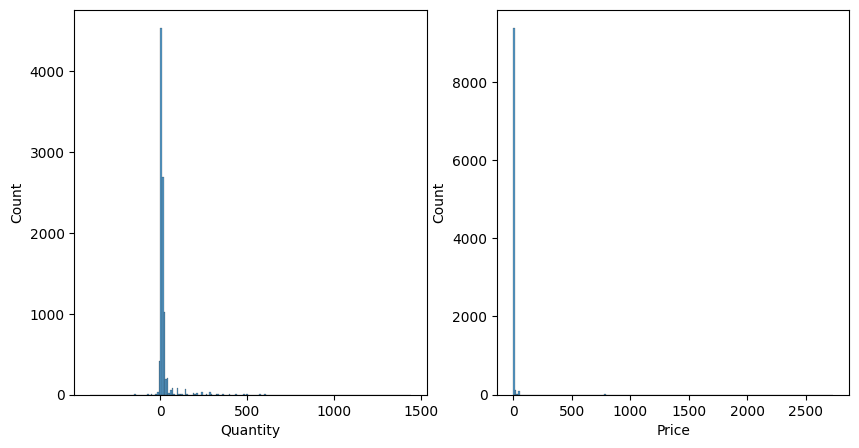

In [ ]:
# The outliers make the majority of data hard to visualise
multi_row_plot(sns.histplot, eire_data[['Quantity', 'Price']], grid=(1,2), size=(10, 5))